

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import zipfile
import os

zip_path = '/content/gdrive/My Drive/archive.zip'

extracted_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Files extracted to: {extracted_path}")

Files extracted to: /content/


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
class FlickrFacesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

def get_dataloader(data_path, image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = FlickrFacesDataset(root_dir=data_path, transform=transform)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

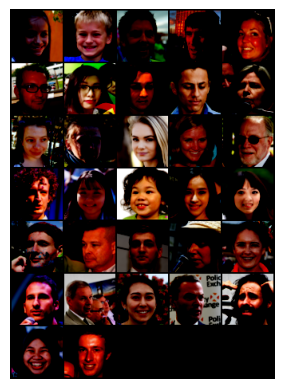

In [ ]:
def plot_batch(images, batch_size):
    img_grid = torchvision.utils.make_grid(images, nrow=int(batch_size**0.5))
    npimg = img_grid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

image_size = 64
batch_size = 32

dataloader = get_dataloader("/content/faces_dataset_small", image_size, batch_size)

for images in dataloader:
    plot_batch(images, batch_size)
    break

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:
discriminator = Discriminator(3, 64)

In [ ]:
latent_size = 100

generator = Generator(latent_size, 3, 64)

In [ ]:
initialize_weights(generator)
initialize_weights(discriminator)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": optim.AdamW(discriminator.parameters(), lr=lr),
    "generator": optim.AdamW(generator.parameters(), lr=lr)
}

fixed_noise = torch.randn(32, latent_size, 1, 1).to(device)

Epoch: 1


Epoch 1/20:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/20], Discriminator Loss: 0.2279327940572091, Generator Loss: 5.842783009163057
Epoch: 2


Epoch 2/20:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/20], Discriminator Loss: 0.033557542072928916, Generator Loss: 7.3459605062850795
Epoch: 3


Epoch 3/20:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/20], Discriminator Loss: 0.018436731159160235, Generator Loss: 7.564865618041067


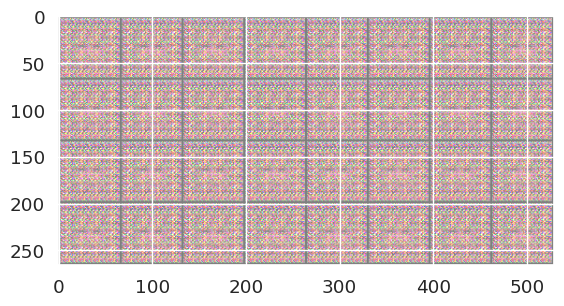

Epoch: 4


Epoch 4/20:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/20], Discriminator Loss: 0.012191203721526146, Generator Loss: 7.739517187831377
Epoch: 5


Epoch 5/20:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/20], Discriminator Loss: 0.06596949936500444, Generator Loss: 9.135750192584414
Epoch: 6


Epoch 6/20:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/20], Discriminator Loss: 0.04666584422529647, Generator Loss: 7.817442325630573


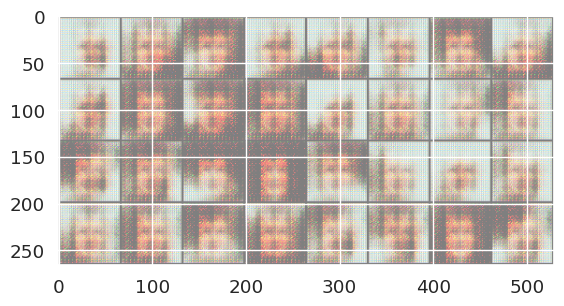

Epoch: 7


Epoch 7/20:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/20], Discriminator Loss: 0.07984398286013554, Generator Loss: 9.181527455647787
Epoch: 8


Epoch 8/20:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/20], Discriminator Loss: 0.12031640978694677, Generator Loss: 8.673463007416387
Epoch: 9


Epoch 9/20:   0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
def show_tensor_images(image_tensor, num_images=32, size=(1, 128, 128)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def fit(model, criterion, optimizer, dataloader, epochs, device, save_dir='./'):
    discriminator = model["discriminator"]
    generator = model["generator"]
    criterion_discriminator = criterion["discriminator"]
    criterion_generator = criterion["generator"]
    optimizer_discriminator = optimizer["discriminator"]
    optimizer_generator = optimizer["generator"]

    discriminator_losses = []
    generator_losses = []

    discriminator.train()
    generator.train()

    for epoch in range(1, epochs):
        print(f"Epoch: {epoch}")
        total_discriminator_loss = 0.0
        total_generator_loss = 0.0

        tqdm_dataloader = tqdm(dataloader, desc=f'Epoch {epoch}/{epochs}', dynamic_ncols=True)
        for real_images in tqdm_dataloader:
            real_images = real_images.to(device)
            b_size = real_images.size(0)

            noise = torch.randn(real_images.size(0), latent_size, 1, 1).to(device)
            fake_images = generator(noise)

            # train discriminator
            discriminator.zero_grad()
            real_outputs = discriminator(real_images).reshape(-1)
            discriminator_loss_real = criterion_discriminator(real_outputs, torch.ones_like(real_outputs))

            fake_outputs = discriminator(fake_images.detach()).reshape(-1)
            discriminator_loss_fake = criterion_discriminator(fake_outputs, torch.zeros_like(fake_outputs))

            discriminator_loss = discriminator_loss_real + discriminator_loss_fake
            discriminator_loss.backward()
            optimizer_discriminator.step()

            # train generator
            generator.zero_grad()
            generator_outputs = discriminator(fake_images).reshape(-1)
            generator_loss = criterion_generator(generator_outputs, torch.ones_like(generator_outputs))
            generator_loss.backward()
            optimizer_generator.step()

            total_discriminator_loss += discriminator_loss.item()
            total_generator_loss += generator_loss.item()

        avg_discriminator_loss = total_discriminator_loss / len(dataloader)
        avg_generator_loss = total_generator_loss / len(dataloader)

        discriminator_losses.append(avg_discriminator_loss)
        generator_losses.append(avg_generator_loss)

        print(f"Epoch [{epoch}/{epochs}], Discriminator Loss: {avg_discriminator_loss}, Generator Loss: {avg_generator_loss}")

        if epoch % 3 == 0:
            with torch.no_grad():
                fake_outputs = generator(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real_images[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake_outputs[:32], normalize=True)
                show_tensor_images(img_grid_fake)

            checkpoint_discriminator = {
                'epoch': epoch,
                'model_state_dict': discriminator.state_dict(),
                'optimizer_state_dict': optimizer_discriminator.state_dict(),
                'loss': avg_discriminator_loss
            }
            checkpoint_generator = {
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizer_generator.state_dict(),
                'loss': avg_generator_loss
            }

            torch.save(checkpoint_discriminator, os.path.join(save_dir, f'discriminator_checkpoint_epoch_{epoch}.pth'))
            torch.save(checkpoint_generator, os.path.join(save_dir, f'generator_checkpoint_epoch_{epoch}.pth'))


    return discriminator_losses, generator_losses

discriminator_losses, generator_losses = fit(model,
                                              criterion,
                                              optimizer,
                                              dataloader,
                                              epochs,
                                              device)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(discriminator_losses, label='Discriminator')
plt.plot(generator_losses, label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
def load_checkpoint(model, optimizer, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss


discriminator = Discriminator(3, 64)
generator = Generator(latent_size, 3, 64)
discriminator_optimizer = optim.AdamW(discriminator.parameters(), lr=0.0001)
generator_optimizer = optim.AdamW(generator.parameters(), lr=0.0001)

discriminator, discriminator_optimizer, _, _ = load_checkpoint(discriminator, discriminator_optimizer, '/content/gdrive/MyDrive/discriminator_checkpoint_epoch_6.pth', device)
generator, generator_optimizer, _, _ = load_checkpoint(generator, generator_optimizer, '/content/gdrive/MyDrive/generator_checkpoint_epoch_6.pth', device)

In [ ]:
def show_images(image_tensor):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    img_grid = torchvision.utils.make_grid(image_unflat)
    npimg = img_grid.numpy()

    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

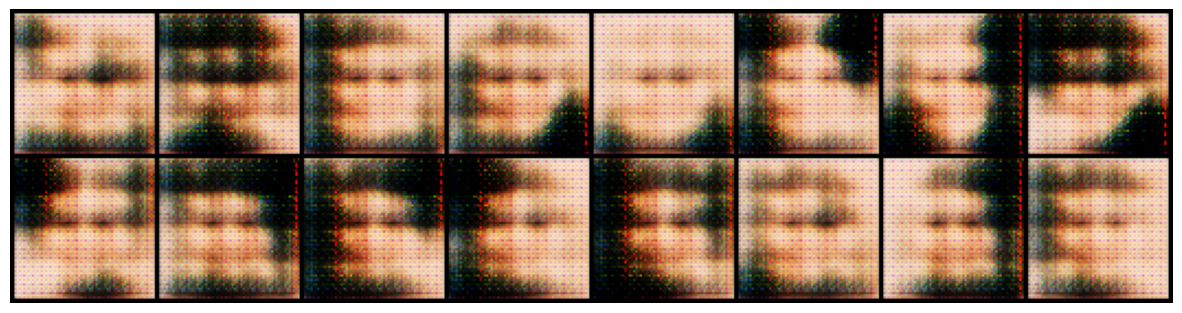

In [ ]:
n_images = 16

generator.to(device)
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)

show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

torch.cuda.empty_cache()

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = FlickrFacesDataset("/content/faces_dataset_small", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

generator.to(device)
num_fake_images = len(dataset)
fake_labels = torch.zeros(num_fake_images, dtype=torch.long)
fake_images = generator(torch.randn(num_fake_images, latent_size, 1, 1, device=device))

discriminator.to(device)
num_real_images = len(dataset)
real_labels = torch.ones(num_real_images, dtype=torch.long)
real_images = []

for batch in dataloader:
    real_images.append(batch)

real_images = torch.cat(real_images, dim=0)

all_images = torch.cat([real_images.detach().cpu(), fake_images.detach().cpu()])
all_labels = torch.cat([real_labels.detach().cpu(), fake_labels.detach().cpu()])

all_images_flat = all_images.view(all_images.size(0), -1)

loo = LeaveOneOut()
accuracies = []

for train_index, test_index in loo.split(all_images_flat):
    X_train, X_test = all_images_flat[train_index], all_images_flat[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

    knn_classifier = KNeighborsClassifier(n_neighbors=1)
    knn_classifier.fit(X_train, y_train.numpy())

    accuracy = knn_classifier.score(X_test, y_test.numpy())
    accuracies.append(accuracy)

final_accuracy = np.mean(accuracies)
print(f"Leave-One-Out 1-NN Classifier Accuracy: {final_accuracy}")


Leave-One-Out 1-NN Classifier Accuracy: 0.9901368119630926


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Метод ближайших соседей, по сути, запоминает обучающий набор данных, поэтому, если данные из одного вероятностного распределения, точность на hold-out обьекте должна быть близка к 1.0

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

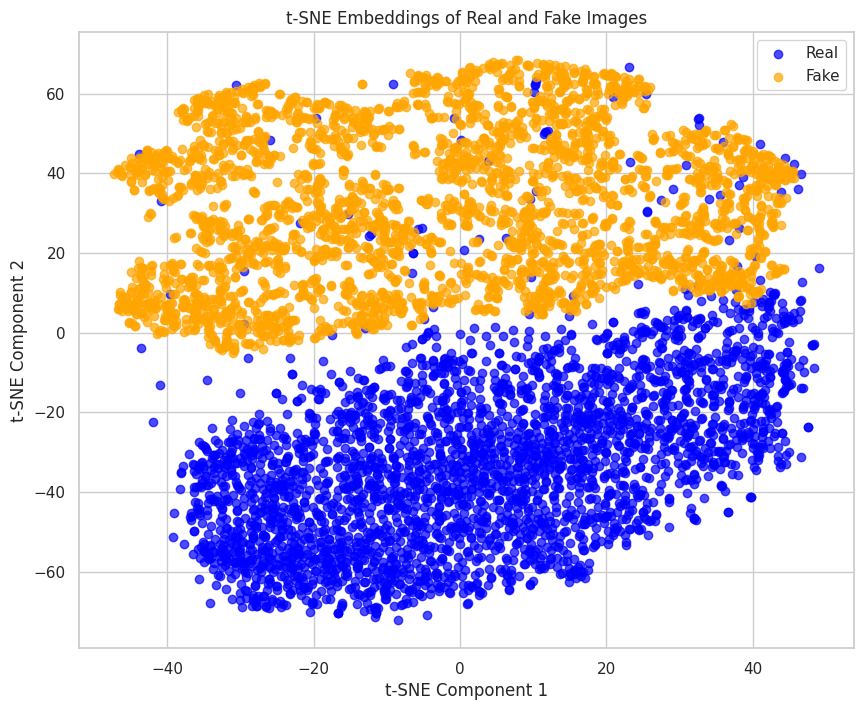

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(all_images_flat)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

plt.scatter(embeddings[all_labels == 1, 0], embeddings[all_labels == 1, 1], label='Real', color='blue', alpha=0.7)

plt.scatter(embeddings[all_labels == 0, 0], embeddings[all_labels == 0, 1], label='Fake', color='orange', alpha=0.7)

plt.title('t-SNE Embeddings of Real and Fake Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


Прокомментируйте получившийся результат:

Исходя из графика TSNE, можно сделать вывод, что вероятностные распределения фейковых и оригинальных изображений ортогональны, и образуют два непересекающихся множества в идеале.